# EDA

분류와 회귀중 회귀와 관련된 문제

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프 그리기
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록  ggplot 스타일 사용


# 그래프에서 마이너스 폰트 깨지는 문제 해결
mpl.rcParams['axes.unicode_minus'] = False

# 그래프에서 한글 폰트 깨지는 문제 해결 : 나눔고딕 사용
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 15

# 서브 plot의 여백 조정(현재 조정안됨)
plt.subplots_adjust(left=0.1, bottom=5, right=1, top=10)
plt.tight_layout()

## 1. 데이터 불러오기

In [3]:
path = "C:/Users/DS-18-D3-001/Dropbox/git/study_python/bike_sharing_demand/data/train.csv"
train = pd.read_csv(path, parse_dates = ["datetime"])
train.shape

(10886, 12)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


### 변수에 대한 설명은 다음과 같다

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

### Data Fields

**datetime** - hourly date + timestamp  
**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter  
**holiday** - whether the day is considered a holiday  
**workingday** - whether the day is neither a weekend nor holiday  
**weather** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy  
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  
**temp** - temperature in Celsius  
**atemp** - "feels like" temperature in Celsius  
**humidity** - relative humidity  
**windspeed** - wind speed  
**casual** - number of non-registered user rentals initiated  
**registered** - number of registered user rentals initiated  
**count** - number of total rentals  

In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
train.temp.describe()

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

In [6]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [7]:
# 결측값을 시각화 해주는 패키지, 설치가 안됨
import missingno as msno
msno.matrix(train, figsize = (12,5))

ModuleNotFoundError: No module named 'missingno'

## EDA

### datetime에 대하여 시각화

#### 연, 월, 일, 시, 요일 별로 나누기

In [8]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 17)

[Text(0.5,0,'workingday'), Text(0.5,1,'근무일 대여량')]

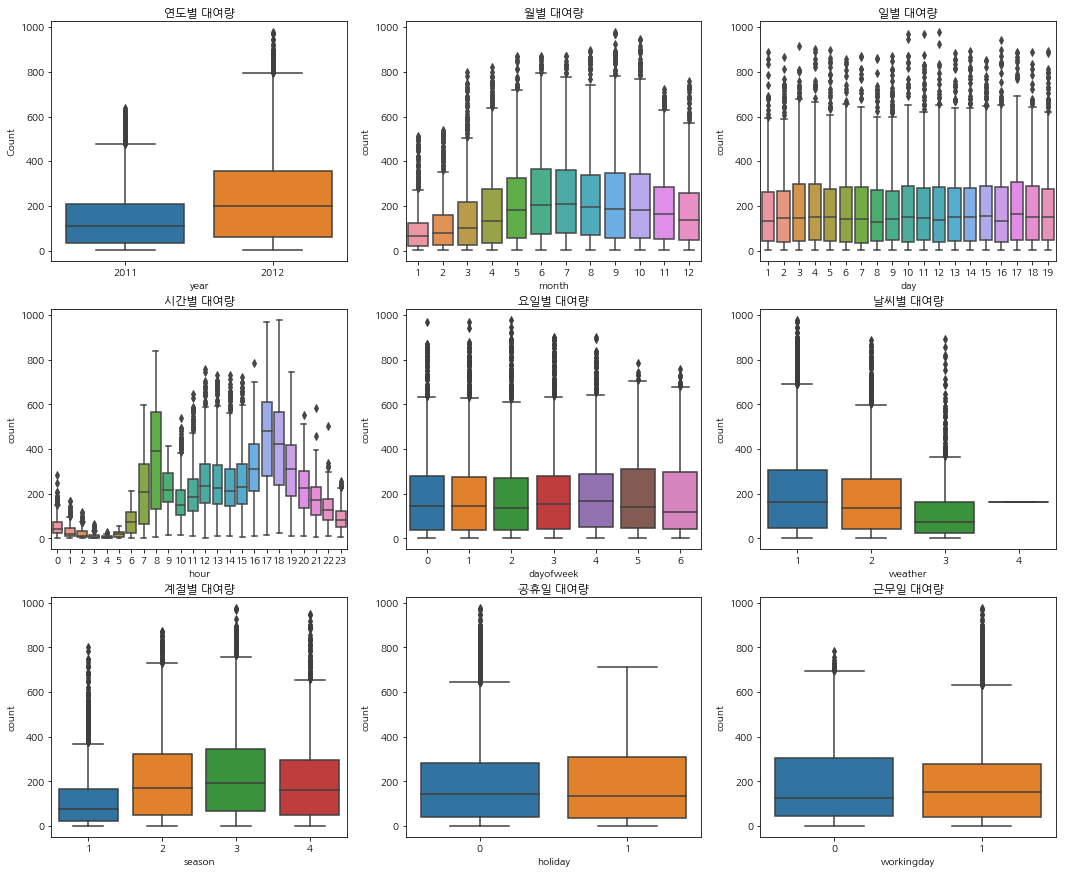

In [9]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(nrows=3, ncols=3)
figure.set_size_inches(18,15)

sns.boxplot(data=train, x="year", y="count", ax=ax1)
sns.boxplot(data=train, x="month", y="count", ax=ax2)
sns.boxplot(data=train, x="day", y="count", ax=ax3)
sns.boxplot(data=train, x="hour", y="count", ax=ax4)
sns.boxplot(data=train, x="dayofweek", y="count", ax=ax5)
sns.boxplot(data=train, x="weather", y="count", ax=ax6)
sns.boxplot(data=train, x="season", y="count", ax=ax7)
sns.boxplot(data=train, x="holiday", y="count", ax=ax8)
sns.boxplot(data=train, x="workingday", y="count", ax=ax9)

ax1.set(ylabel='Count',title="연도별 대여량")
ax2.set(xlabel='month',title="월별 대여량")
ax3.set(xlabel='day', title="일별 대여량")
ax4.set(xlabel='hour', title="시간별 대여량")
ax5.set(xlabel='dayofweek', title="요일별 대여량")
ax6.set(xlabel='weather', title="날씨별 대여량")
ax7.set(xlabel='season', title="계절별 대여량")
ax8.set(xlabel='holiday', title="공휴일 대여량")
ax9.set(xlabel='workingday', title="근무일 대여량")

1. 2011년도에 비해 2012년도의 대여량이 증가.
2. 월별로는 6월이 가장 대여량이 많고, 1월이 가장 적음.
3. 일별 대여량에는 큰 차이가 없음.
4. 시간별로는 출근,퇴근 시간에 대여량이 증가함.
5. 요일별 대여량에도 큰 차이가 없음.
6. 날씨별 대여량에는 맑은 날씨일때가 가장 높고, 강한비 일때는 가장 적음.
7. 계절별 대여량에서는 봄에 대여량이 적고 가을에 가장 많음.
8. 공휴일에 따른 대여량에 차이가 없음.
9. 근무일에 따른 대여량에 차이가 없음.

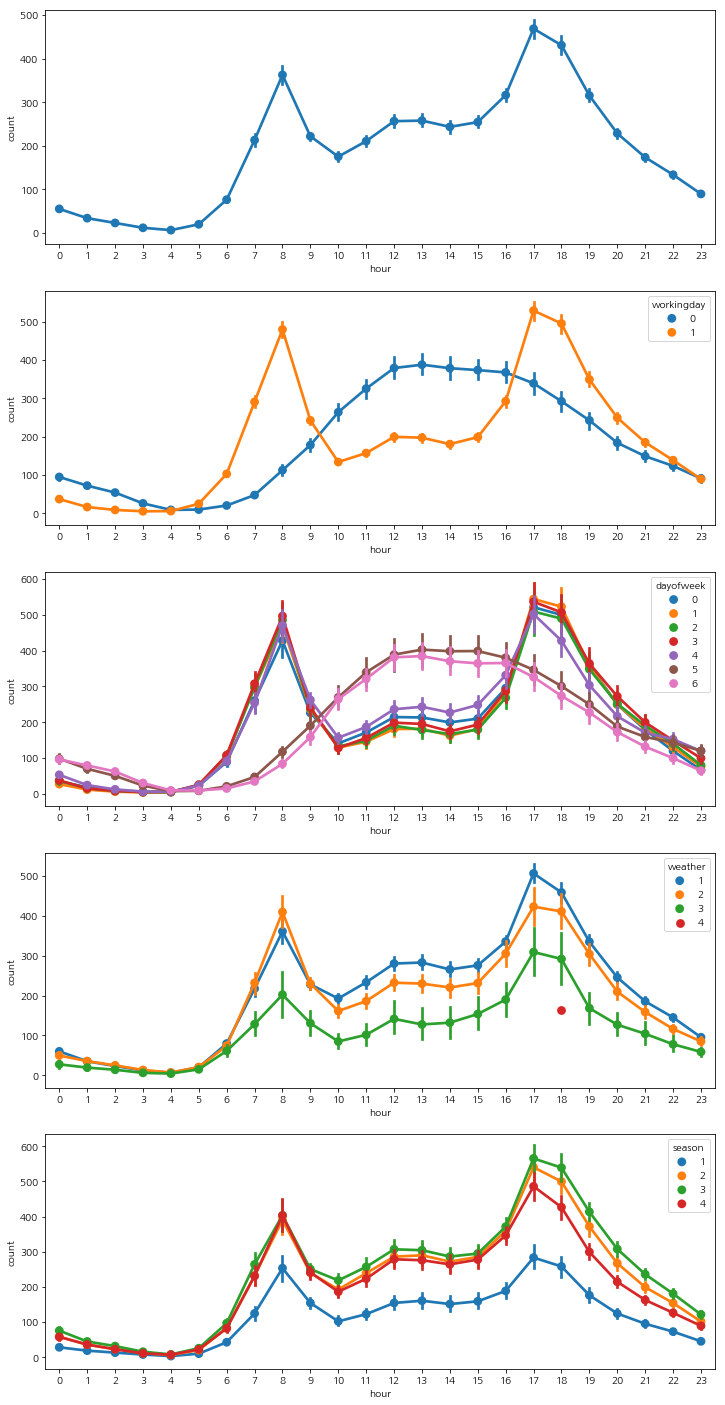

In [10]:
fig, (ax1, ax2, ax3, ax4,ax5) = plt.subplots(nrows = 5)
fig.set_size_inches(12,25)

sns.pointplot(data = train, x = "hour", y = "count", ax = ax1)
sns.pointplot(data = train, x = "hour", y = "count", hue = "workingday", ax = ax2)
sns.pointplot(data = train, x = "hour", y = "count", hue = "dayofweek", ax = ax3)
sns.pointplot(data = train, x = "hour", y = "count", hue = "weather", ax = ax4)
sns.pointplot(data = train, x = "hour", y = "count", hue = "season", ax = ax5)

시간별로 근무일, 요일, 날씨, 계절별 대여량 확인해 보기

1. 시간별 대여량은 출퇴근 시간에 증가.
2. 근무일에는 출퇴근 시간에 증가하나, 근무일이 아닌날에는 심시간에 증가하는 추세.
3. 평일에는 출퇴근 시간에 증가하나, 토요일 일요일과 같이 휴일에는 점심시간에 증가하는 추세.
4. 날씨가 나쁠수록 대여량이 전체적으로 감소. 시간별로 날씨에 따른 대여량의 추세에는 영향을 미치지 않음.
5. 봄에 가장 대여량이 적고 가을에 가장 높음. 시간별로 계절에 따른 대여량의 추세에는 영향을 미치지 않음.

AttributeError: 'numpy.ndarray' object has no attribute 'bar'

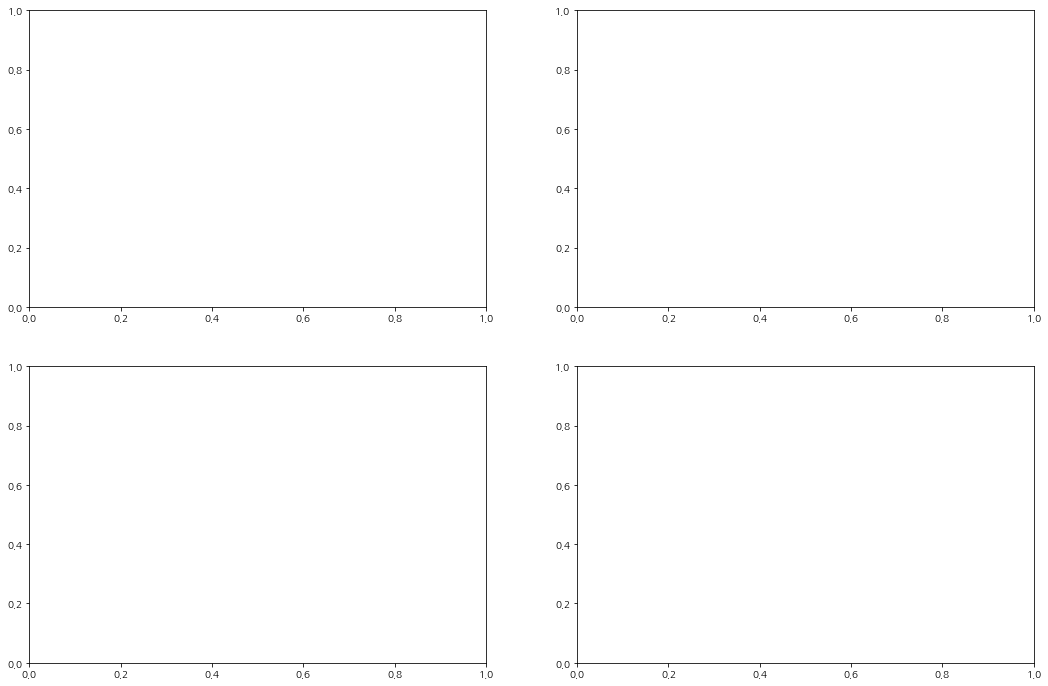

In [4]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(18,12)

sns.countplot(data = train, x = "windspeed", ax = axes[0])


In [12]:
corrMatt = train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]]
corrMatt = corrMatt.corr()
print(round(corrMatt, 3))

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

             temp  atemp  casual  registered  humidity  windspeed  count
temp        1.000  0.985   0.467       0.319    -0.065     -0.018  0.394
atemp       0.985  1.000   0.462       0.315    -0.044     -0.057  0.390
casual      0.467  0.462   1.000       0.497    -0.348      0.092  0.690
registered  0.319  0.315   0.497       1.000    -0.265      0.091  0.971
humidity   -0.065 -0.044  -0.348      -0.265     1.000     -0.319 -0.317
windspeed  -0.018 -0.057   0.092       0.091    -0.319      1.000  0.101
count       0.394  0.390   0.690       0.971    -0.317      0.101  1.000


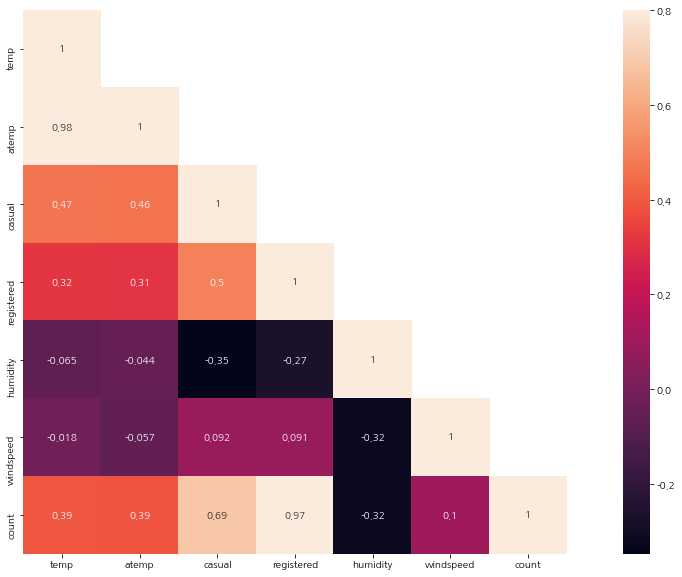

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corrMatt, mask = mask, vmax = 0.8, square = True, annot = True)

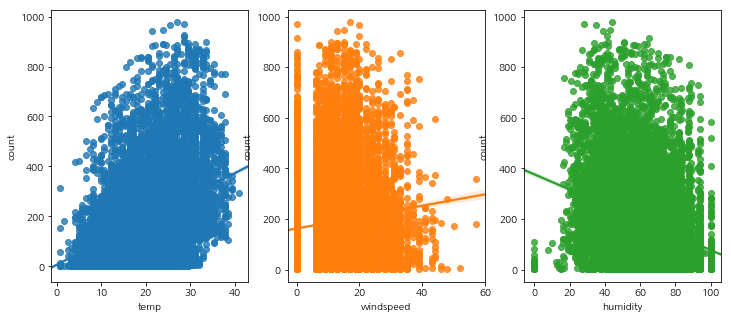

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3)
fig.set_size_inches(12, 5)

sns.regplot(data = train, x = "temp", y = "count", ax = ax1)
sns.regplot(data = train, x = "windspeed", y = "count", ax = ax2)
sns.regplot(data = train, x = "humidity", y = "count", ax = ax3)

In [6]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train["year_month"] = train["datetime"].apply(concatenate_year_month)
train[["datetime", "year_month"]].head()

,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


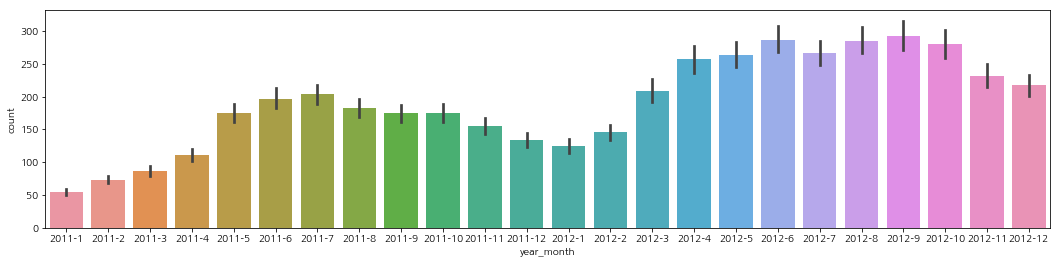

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(18,4)
sns.barplot(data = train, y = "count", x = "year_month")

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([  1,   1,   1, ..., 968, 970, 977], dtype=int64)),
 (169.82942673231383, 191.5741319125482, 0.9372682766213174))

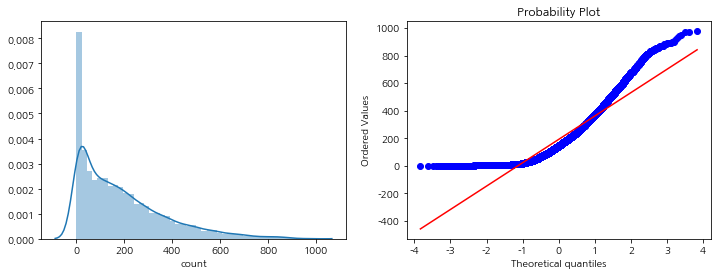

In [8]:
# count값의 데이터 분포도를 파악

fig, axes = plt.subplots(ncols = 2)
fig.set_size_inches(12, 4)

sns.distplot(train["count"], ax = axes[0])
stats.probplot(train["count"], dist = "norm", fit = True, plot = axes[1])